# Mapping the Antibody Response

For the final exercise, we will visualize the affinity of the antibody response to different regions of the HIV envelope protein. The data come from experiments in which animals are given an HIV vaccine, and pre- and post-vaccination samples are tested on an HIV peptide array containing thousands of HIV envelope sequences. Each array has triplicates of each sequence. 

We need to do the following for each animal:

- read in pre-vaccination peptide array data a text file
- read in post-vaccination peptide array data a text file
- find the change in fluorescence reading from pre- to post-vaccination sample
- find the median value across the 3 replicates per sequence 
- extract the clade data for each peptide
- read in a metadata file showing the mapping of peptide sequence to a region on the HIV envelope
- find the region each sequence is mapped to

Then, the investigator has asked us to plot the following heatmap where each cell contains the sum of values for sequences belonging to that clade, normalized by the number of such sequences in each clade.

![heatmap](figs/heatmap.png)

This non-trivial exercise will clearly test your mastery of the workshop data manipulation and visualization lessons!

In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
excel_path = os.path.join('data', 'capstone2', 'RM30pre_pla.xlsx')

In [3]:
meta = pd.read_excel(excel_path, sheetname='Library', na_values='-')

In [4]:
meta.columns

Index([                 'OriNum',                  'NewNum',
                    'PeptideSeq',                  'Region',
                          'Seqs',                 'N.ident',
                         'Batch',                        12,
                              11,                        10,
                               9,                         8,
                               1,                         2,
                               3,                         4,
                               5,                         6,
                               7,             'Unnamed: 19',
                   'Unnamed: 20',             'Unnamed: 21',
                   'Unnamed: 22',             'Unnamed: 23',
                   'Unnamed: 24',             'Unnamed: 25',
                   'Unnamed: 26',             'Unnamed: 27',
                   'Unnamed: 28',             'Unnamed: 29',
                   'Unnamed: 30',             'Unnamed: 31',
                   'Unna

<font color=red>Need correct file matching Excel worksheets</font>
```python
meta_path = os.path.join('data', 'capstone2', 'Revised Peptides_Bette_HIV_Complete_07Feb12.txt')
meta = pd.read_table(meta_path, na_values='-')
meta.dropna(axis=0, how='all', inplace=True)

data_path = os.paht.join('data', 'capstone2', 'RM30pre_pla.txt')
data = pd.read_data(data_path, skip_rows=27)
```

In [5]:
data = pd.read_excel(excel_path, sheetname='RM30pre', skiprows=27)

In [6]:
data.columns

Index(['Flags', 'Normalisation', 'AutoFlag', 'Block', 'Column', 'Row', 'Name',
       'ID', 'X', 'Y', 'Dia.', 'F635 Median', 'F635 Mean', 'F635 SD',
       'F635 CV', 'B635', 'B635 Mean', 'B635 Median', 'B635 SD', 'B635 CV',
       '% > B635+1SD', '% > B635+2SD', 'F635 % Sat.', 'F532 Median',
       'F532 Mean', 'F532 SD', 'F532 CV', 'B532', 'B532 Median', 'B532 Mean',
       'B532 SD', 'B532 CV', '% > B532+1SD', '% > B532+2SD', 'F532 % Sat.',
       'F635 Total Intensity', 'F532 Total Intensity', 'SNR 635', 'SNR 532',
       'Ratio of Medians (635/532)', 'Ratio of Means (635/532)',
       'Median of Ratios (635/532)', 'Mean of Ratios (635/532)',
       'Ratios SD (635/532)', 'Rgn Ratio (635/532)', 'Rgn R2 (635/532)',
       'Log Ratio (635/532)', 'F635 Median - B635', 'F532 Median - B532',
       'F635 Mean - B635', 'F532 Mean - B532', 'Sum of Medians (635/532)',
       'Sum of Means (635/532)', 'F Pixels', 'B Pixels', 'Circularity',
       'Annotation'],
      dtype='object')

## Example of merging data and metadata on peptide sequence

In [7]:
t1 = data.ix[:3, ['ID']]
t1

,ID
0,WVTVYYGVPVWKDAE
1,MGIQRNWQHLWRWGT
2,FCASDAKSYEKEVHN
3,WLIWSILGFWIGNME


In [8]:
t2 = meta.ix[:, ['PeptideSeq', 'Region']]
t2.head(4)

,PeptideSeq,Region
0,MRVMGIQRNWQHLWR,1.0
1,KGIRKNYQHLWRWGT,2.0
2,TTLFCASDAKSYKTE,17.0
3,WNSSWSNKSQSEIWD,198.0


In [9]:
pd.merge(t1, t2, left_on='ID', right_on='PeptideSeq', how='left')

,ID,PeptideSeq,Region
0,WVTVYYGVPVWKDAE,WVTVYYGVPVWKDAE,12.0
1,MGIQRNWQHLWRWGT,MGIQRNWQHLWRWGT,2.0
2,FCASDAKSYEKEVHN,FCASDAKSYEKEVHN,18.0
3,WLIWSILGFWIGNME,WLIWSILGFWIGNME,6.0


## Merge data and metadata

In [10]:
df = pd.merge(data, meta, left_on='ID', right_on='PeptideSeq', how='left')

### Calculate median and cv for  column `F635 Median - B635`

In [11]:
def cv(x):
    x = np.float64(x)
    return np.round(100.0*x.std(ddof=1)/x.mean(), 1)

In [12]:
new_cols = ['ID', 'NewNum', 'Region', 'Seqs']

df1 = df.groupby(new_cols).agg({'F635 Median - B635': [np.median, cv]}).reset_index()
df1.columns = [' '.join(col).strip() for col in df1.columns.values]
df1.sort_values(['Region', 'NewNum']).head(10)

,ID,NewNum,Region,Seqs,F635 Median - B635 median,F635 Median - B635 cv
1023,MRVMGIQRNWQHLWR,E1,1.0,M,5312,11.3
1028,MRVRGIWKNWPQWLI,E1426,1.0,1086,52,93.4
1024,MRVMGTQKNCQQWWI,E1427,1.0,TV1,207,23.3
1025,MRVREILRNWQRWWT,E1920,1.0,ZM651,97,82.2
1022,MRVMGIQRNCQHLWR,E2,1.0,A,5844,20.4
1020,MRVKGIRKNYQHLWR,E3,1.0,B,9730,34.2
1027,MRVRGILRNWQQWWI,E4,1.0,C,192,46.9
1026,MRVRGIERNYQHLWR,E5,1.0,D,5225,29.8
1019,MRVKETQMNWPNLWK,E6,1.0,CRF1,1305,15.2
1021,MRVMGIQKNYPLLWR,E7,1.0,CRF2,1,173.3


### Give each clade in `Seqs` column its own row to allow analysis by clade

This is rather tricky code.

In [13]:
df1['clades'] = df1.Seqs.str.split('&')

In [14]:
s = df1.apply(lambda x: pd.Series(x['clades']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'clade'
df2 = df1.drop(['Seqs', 'clades'], axis=1).join(s)

#### Unpacking the use of `apply` in the above code

In [15]:
df1.apply(lambda x: x.shape, axis=1)[:3]

0    (7,)
1    (7,)
2    (7,)
dtype: object

In [16]:
df1.apply(lambda x: x.index, axis=1)[:3]

,ID,NewNum,Region,Seqs,F635 Median - B635 median,F635 Median - B635 cv,clades
0,ID,NewNum,Region,Seqs,F635 Median - B635 median,F635 Median - B635 cv,clades
1,ID,NewNum,Region,Seqs,F635 Median - B635 median,F635 Median - B635 cv,clades
2,ID,NewNum,Region,Seqs,F635 Median - B635 median,F635 Median - B635 cv,clades


In [17]:
df1.apply(lambda x: x['clades'], axis=1)[:3]

0                [C]
1                [D]
2    [A, CRF1, CRF2]
dtype: object

In [18]:
max(map(len, df1.clades.dropna()))

13

In [19]:
df1.apply(lambda x: pd.Series(x['clades']), axis=1)[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,CRF1,CRF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df1.apply(lambda x: pd.Series(x['clades']), axis=1)[:6].stack()

0  0       C
1  0       D
2  0       A
   1    CRF1
   2    CRF2
3  0       M
4  0       M
   1       A
   2       C
   3    CRF1
   4    CRF2
5  0       D
dtype: object

In [21]:
df1.apply(lambda x: pd.Series(x['clades']), axis=1)[:6].stack().index

MultiIndex(levels=[[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
           labels=[[0, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5], [0, 0, 0, 1, 2, 0, 0, 1, 2, 3, 4, 0]])

In [22]:
df1.apply(lambda x: pd.Series(x['clades']), axis=1)[:6].stack().reset_index(level=1)

,level_1,0
0,0,C
1,0,D
2,0,A
2,1,CRF1
2,2,CRF2
3,0,M
4,0,M
4,1,A
4,2,C
4,3,CRF1


In [23]:
df1.apply(lambda x: pd.Series(x['clades']), axis=1)[:6].stack().reset_index(level=1, drop=True)

0       C
1       D
2       A
2    CRF1
2    CRF2
3       M
4       M
4       A
4       C
4    CRF1
4    CRF2
5       D
dtype: object

## Reporting and plotting

### Consolidate clades into major groups

In [24]:
clade_map = {
  'CRF2': 'C',
  'CRF1': 'C',
  'A244': 'A',
  'MN' : 'M',
}
df2['major_clade'] = df2.clade.replace(clade_map)

#### Plot all clades

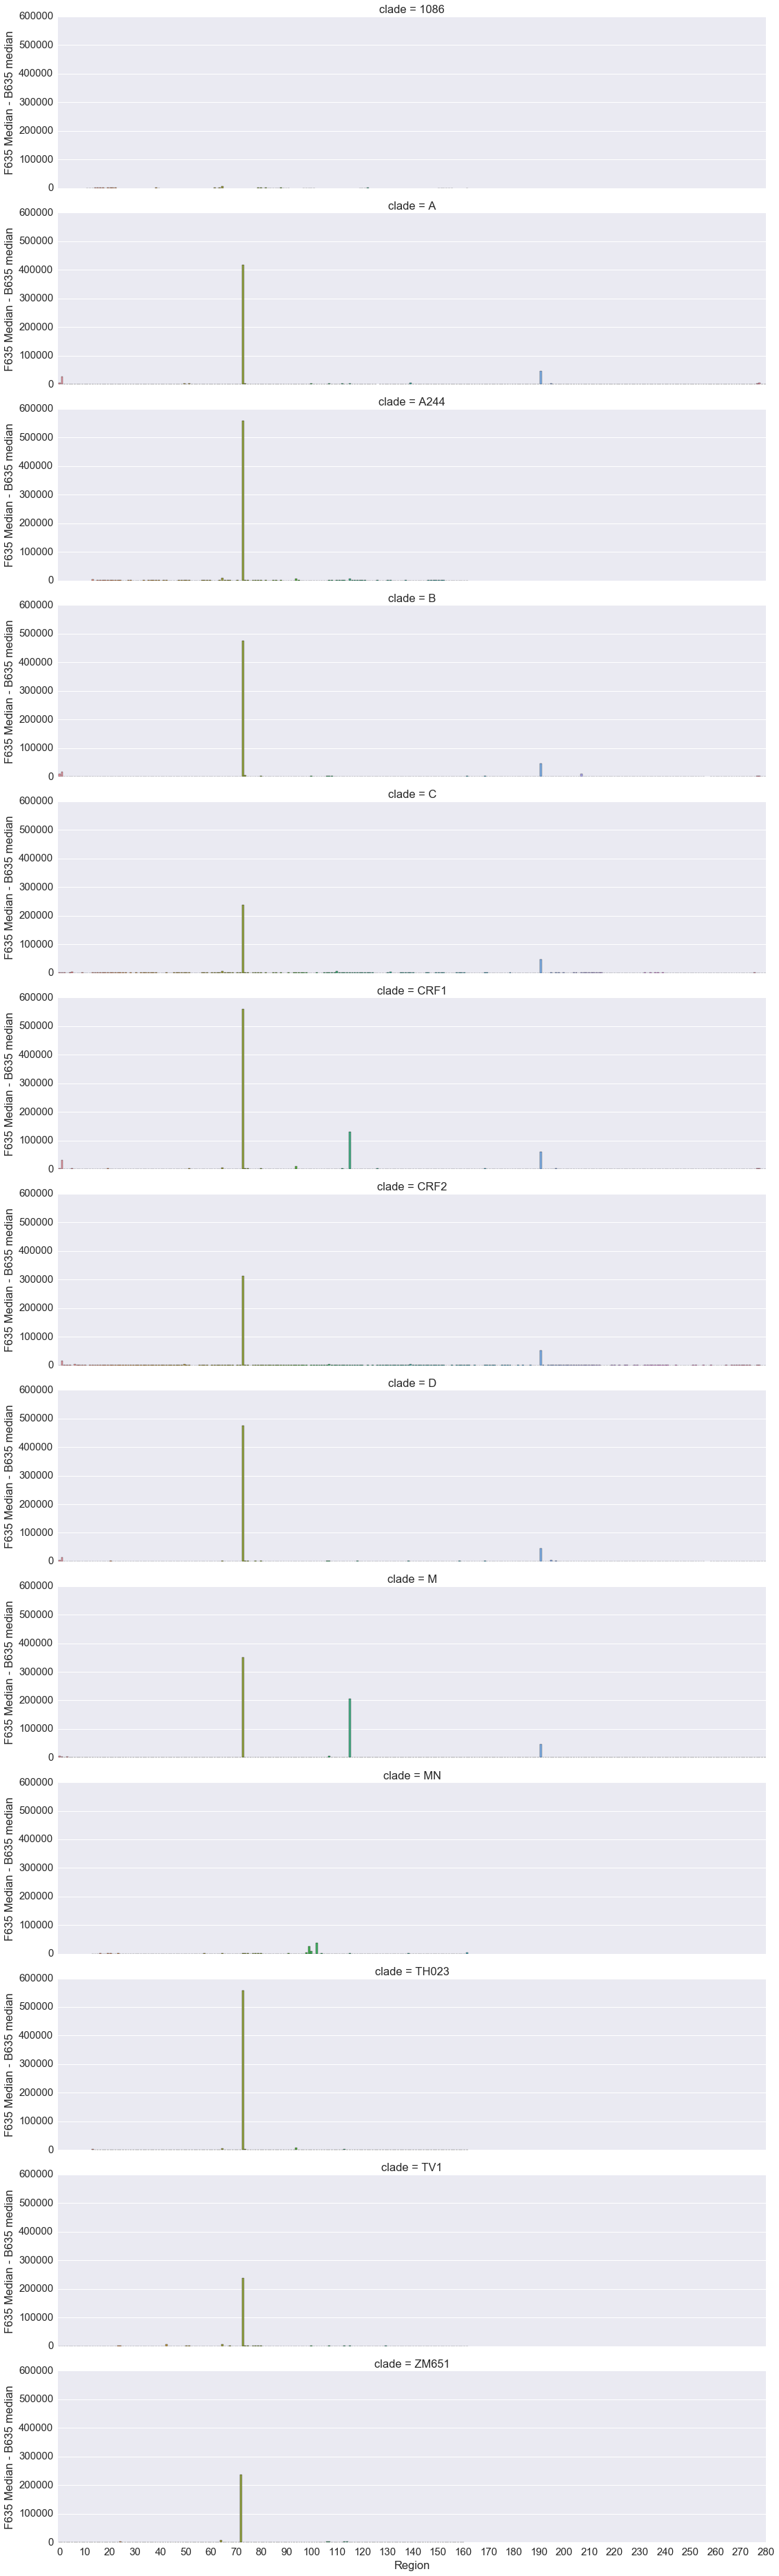

In [25]:
sns.factorplot(data=df2, x='Region', y='F635 Median - B635 median', 
               row='clade', row_order=sorted(df2.clade.dropna().unique()), 
               kind='bar', ci=None, aspect=4)
xx = np.arange(0, df2.Region.max() + 9, 10).astype('int')
plt.xticks(xx, xx)
plt.ylim([-1000, plt.ylim()[1]])
plt.savefig('clade.png')
pass

#### Plot consensus clades

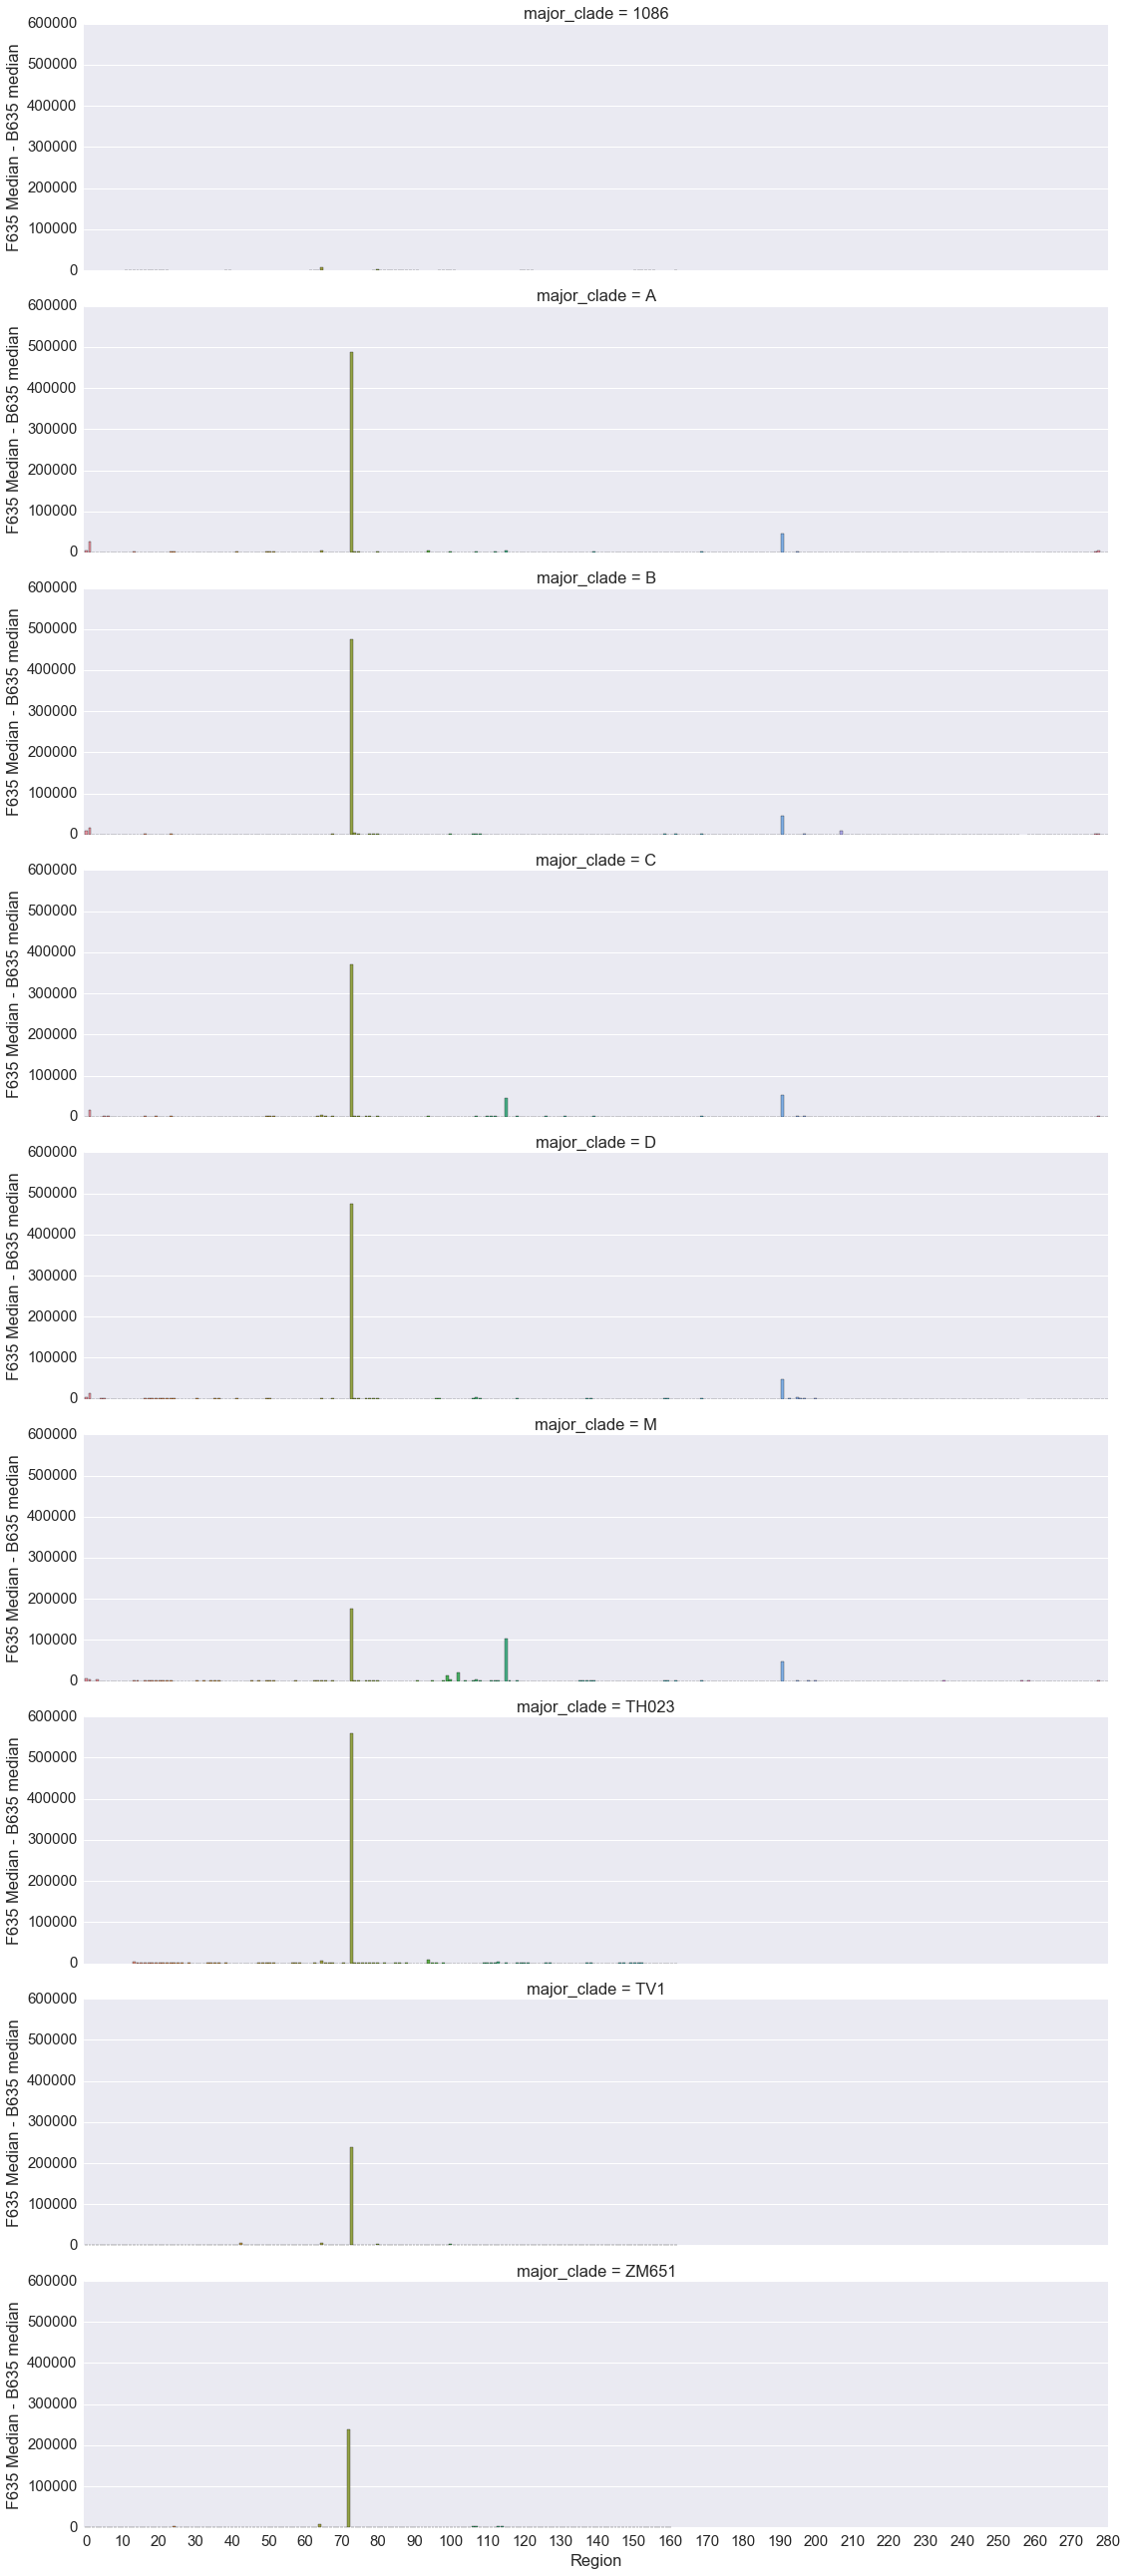

In [26]:
sns.factorplot(data=df2, x='Region', y='F635 Median - B635 median', 
               row='major_clade', row_order=sorted(df2.major_clade.dropna().unique()),
               kind='bar', ci=None, aspect=4)
xx = np.arange(0, df2.Region.max() + 9, 10).astype('int')
plt.xticks(xx, xx)
plt.ylim([-1000, plt.ylim()[1]])
plt.savefig('major_clade.png')
pass

#### Plot consensus clades for gp120 (Region 1 - 162)

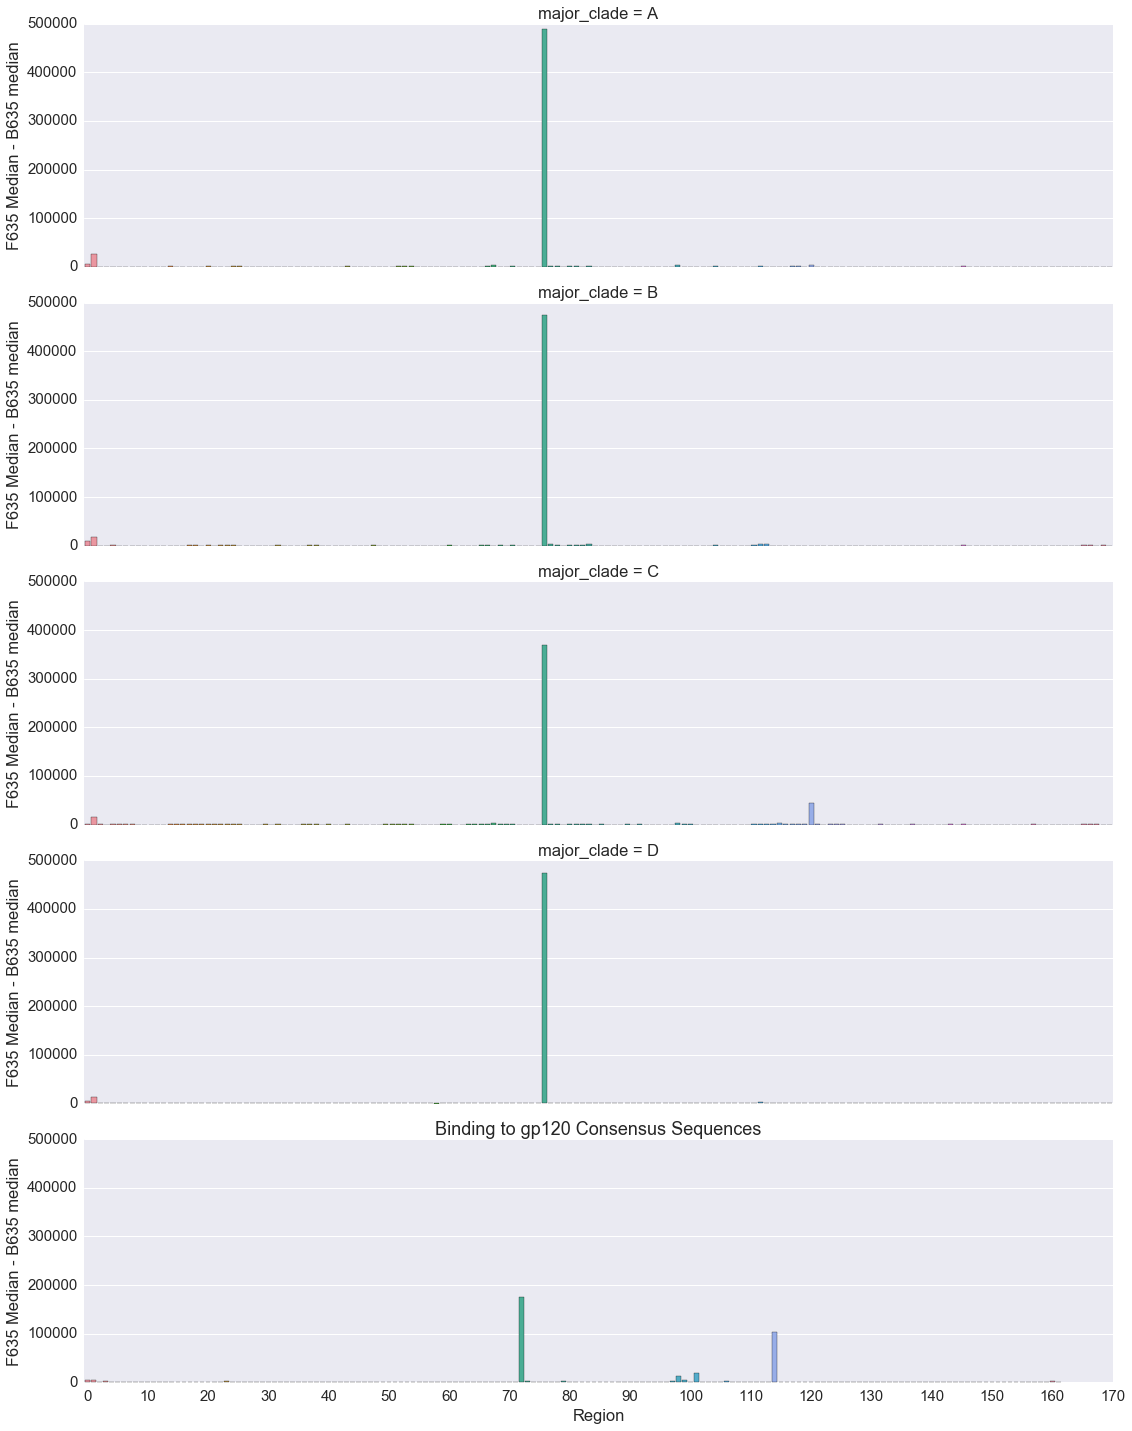

In [27]:
df3 = df2[(df2.Region < 163) & df2.major_clade.isin(['A', 'B', 'C', 'D', 'M', 'CR1', 'CR2'])]
sns.factorplot(data=df3, x='Region', y='F635 Median - B635 median', 
               row='major_clade', row_order=sorted(df3.major_clade.dropna().unique()),
               kind='bar', aspect=4, ci=None)
xx = np.arange(0, df3.Region.max() + 9, 10).astype('int')
plt.xticks(xx, xx)
plt.ylim([-1000, plt.ylim()[1]])
plt.title('Binding to gp120 Consensus Sequences')
plt.savefig('gp120_consensus.png')
pass

#### Heatmaps

In [162]:
hm = df3.groupby(['Region', 'major_clade'])[['F635 Median - B635 median']].mean()
hm = hm.unstack().T.reset_index(level=0, drop=True)

In [165]:
hm = hm - hm.min().min()
hm.columns = hm.columns.astype(int)

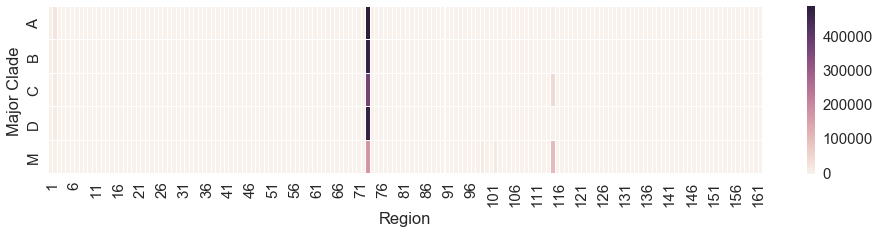

In [169]:
fig, ax = plt.subplots(1,1,figsize=(16,3))
sns.heatmap(hm, ax=ax, cbar=True, linewidth=0.01)
ax.set_xticks(range(hm.columns[0], hm.columns[-1]+1, 5))
ax.set_xticklabels(range(hm.columns[0], hm.columns[-1]+1, 5))
ax.set_ylabel('Major Clade')
pass